In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import time
import os
import re

In [2]:
cuda = torch.cuda.is_available()
print(cuda)

True


In [3]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

In [4]:
class MyDataset(Dataset):
    def __init__(self, values):
        self.values = values

    def __len__(self):
        return len(self.values)

    def __getitem__(self, index):
        X, Y = self.values[index]
        return np.array(X).astype("float"), np.array(Y).astype("long")

In [5]:
def readFile(path):
    lines = list()
    with open(path) as file:
        csv_reader = file.readlines()
        line_count = 0
        for row in csv_reader:
            row = re.split(r'\t+', row.rstrip('\t'))[1:]
            values = row.pop(-1)
            values = values.split(';')
            for r in values:
                chunk = re.findall('\d*\.?\d+',r)
                chunk = list(map(float, chunk)) 
                row.append(chunk)
            lines.append(row)
    features = []
    for x in lines:
        features.append([x[2], x[3], x[4], max(x[10])])
    filterUnk = list(filter(lambda x: 'Unknown' not in x, features))
    notGauges = ['PowerPICC', 'PICC', 'PowerPort', 'CentralLine', 'Other']
    notivLoc = ['Other', 'PowerPort', 'CentralLine', 'PICC', 'PowerPICC']
    filterGauge = list(filter(lambda x: x[0] not in notGauges, filterUnk))
    filterIV = list(filter(lambda x: x[1] not in notivLoc, filterGauge))
    return filterIV

In [6]:
original = readFile("SN-SRMC-CT-1.txt") + readFile("SN-SRMC-CT-2.txt")

In [7]:
gaugeTypes = set()
ivLocation = set()
protocol = dict()
pressure = set()
for inputX in original:
    gaugeTypes.add(inputX[0])
    ivLocation.add(inputX[1])
    if inputX[2] in protocol:
        protocol[inputX[2]] = protocol[inputX[2]] + [inputX[3]]
    else:
        protocol[inputX[2]] = [inputX[3]]
    pressure.add(inputX[3])

"Gauge Types:", len(gaugeTypes), "IV Locations:", len(ivLocation), "Protocols:", len(protocol), "Pressures:", len(pressure)

('Gauge Types:',
 6,
 'IV Locations:',
 10,
 'Protocols:',
 3360,
 'Pressures:',
 25891)

In [8]:
def parseProtocol(x):
    protocol = x.split(" ")
    Contrast = 0
    Saline = 0
    Mixed = 0
    AmountC = 0
    AmountS = 0
    AmountM = 0
    PercentM = 0
    Flowrate = 0
    for i in protocol:
        if i[0] == "@":
            FlowRate = float(i[1:])
        if i[0] == "C":
            Contrast = 1
            AmountC = int(i[1:])
        if i[0] == "S":
            Saline = 1
            AmountS = int(i[1:])
        if i[0] == "R":
            rprot = i.split("%")
            Mixed = 1
            AmountM = int(rprot[0][1:])
            PercentM = int(rprot[1][1:])
    return [Contrast, Saline, Mixed, AmountC, AmountS, AmountM, PercentM, FlowRate]
    print(v)

In [9]:
def roundup(x):
    return int(math.ceil(x/100.0))*100

mapGauge = dict()
for i, x in enumerate(sorted(list(gaugeTypes))):
    mapGauge[x] = i
mapIV = dict()
for i, x in enumerate(sorted(list(ivLocation))):
    mapIV[x] = i
mapPressure = dict()
buckets = []
count = 0
bucketSize = 20
for p in range(int(min(pressure)), int(roundup(max(pressure))), bucketSize):
    buckets.append(p)
    mapPressure[p] = count
    count += 1
result = []
for v in original: 
    for p in range(len(buckets) - 1):
        if (v[3] >= buckets[p]) and (v[3] < buckets[p + 1]):
            pressureV = buckets[p]
    result.append(([mapGauge[v[0]], mapIV[v[1]]] + parseProtocol(v[2]) , mapPressure[pressureV]))

In [10]:
half = len(result)//2

training_set = result[:half]
validation_set = result[half:]

In [11]:
num_workers = 8 if cuda else 0 

train_dataset = MyDataset(training_set)
train_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda                    else dict(shuffle=True, batch_size=64)
train_loader = DataLoader(train_dataset, **train_loader_args)

val_dataset = MyDataset(validation_set)
val_loader_args = dict(shuffle=False, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda                    else dict(shuffle=False, batch_size=1)
val_loader = DataLoader(val_dataset, **val_loader_args)

In [12]:
input_size = len(train_dataset.__getitem__(0)[0])
output_size = len(buckets)
hidden_size = int(input_size**2)//2

input_size, output_size, hidden_size

(10, 65, 50)

In [13]:
class MyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()
        self.b1 = nn.BatchNorm1d(hidden_size)
        self.layer2 = nn.Linear(hidden_size, int(hidden_size))
        self.act2 = nn.ReLU()
        self.b2 = nn.BatchNorm1d(int(hidden_size))
        self.layer3 = nn.Linear(int(hidden_size), output_size)

    def forward(self, input_val):
        h = input_val
        h = self.layer1(h)
        h = self.act1(h)
        h = self.b1(h)
        h = self.layer2(h)
        h = self.act2(h)
        h = self.b2(h)
        h = self.layer3(h)
        return h

In [14]:
model = MyNetwork(input_size, hidden_size, output_size)
model = model.float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

MyNetwork(
  (layer1): Linear(in_features=10, out_features=50, bias=True)
  (act1): ReLU()
  (b1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (act2): ReLU()
  (b2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=50, out_features=65, bias=True)
)


In [15]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
        
    start_time = time.time()
    og_time = start_time
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data.float())
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()
        
        loss = criterion(outputs, target)
        running_loss += loss.item()
        if (batch_idx%200 == 0):
            end_time = time.time()
            print("Training:", "Batch Number " + str(batch_idx), "Running Loss:", running_loss, "Time:", end_time - start_time, 's')
            start_time = end_time
            
        loss.backward()
        optimizer.step()
    end_time = time.time()
    
    running_loss /= len(train_loader)
    acc = (correct_predictions/total_predictions)*100.0
    print('Training Accuracy: ', acc, "    ", 'Training Loss: ', running_loss)
    return running_loss, acc

In [16]:
def val_model(model, dev_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(dev_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data.float())

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()
            
        running_loss /= len(dev_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Validation Accuracy: ', acc, "    ", 'Validation Loss: ', running_loss)
        return running_loss, acc

In [17]:
from tqdm import tqdm

n_epochs = 5
Train_loss = []
Train_acc = []
Val_loss = []
Val_acc = []

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter("./runs/training")

for epoch in tqdm(range(n_epochs)):
    print("Epoch " + str(epoch)) 
            
    train_l, train_a = train_epoch(model, train_loader, criterion, optimizer)
    val_l, val_a = val_model(model, val_loader, criterion)
    
#     for name, param in model.named_parameters():
#         writer.add_histogram('grad_' + name, param.grad.data, epoch)
    
    Train_loss.append(train_l)
    Train_acc.append(train_a)
    Val_loss.append(val_l)
    Val_acc.append(val_a)
    
#     writer.add_scalars('loss', {'train': train_l, 'val': val_l}, epoch)
#     writer.add_scalars('acc', {'train': train_a, 'val': val_a}, epoch)
    
    print("Saving the Model Version " + str(epoch))
    torch.save(model, './model_final.pt')
    torch.save(optimizer, './adam_model_final.pt')
    print('='*115)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
Training: Batch Number 0 Running Loss: 4.325794219970703 Time: 0.4627668857574463 s
Training Accuracy:  70.53049289891395      Training Loss:  1.679648072209977


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
 20%|██        | 1/5 [00:01<00:07,  1.92s/it]

Validation Accuracy:  88.02398782707283      Validation Loss:  0.7823795739931004
Saving the Model Version 0
Epoch 1
Training: Batch Number 0 Running Loss: 0.6266815066337585 Time: 0.28935861587524414 s
Training Accuracy:  88.56367108246808      Training Loss:  0.5013275378532992


 40%|████      | 2/5 [00:03<00:05,  1.81s/it]

Validation Accuracy:  93.71065429483546      Validation Loss:  0.5809828354657152
Saving the Model Version 1
Epoch 2
Training: Batch Number 0 Running Loss: 0.39987829327583313 Time: 0.2759110927581787 s
Training Accuracy:  91.69650316266858      Training Loss:  0.3379542485220742


 60%|██████    | 3/5 [00:05<00:03,  1.74s/it]

Validation Accuracy:  94.0448130799296      Validation Loss:  0.5882848735529048
Saving the Model Version 2
Epoch 3
Training: Batch Number 0 Running Loss: 0.4693295657634735 Time: 0.27954673767089844 s
Training Accuracy:  92.88996300274496      Training Loss:  0.2965511581824936


 80%|████████  | 4/5 [00:06<00:01,  1.68s/it]

Validation Accuracy:  93.51075573589522      Validation Loss:  0.5305583771062261
Saving the Model Version 3
Epoch 4
Training: Batch Number 0 Running Loss: 0.2100902795791626 Time: 0.2819485664367676 s
Training Accuracy:  94.23558897243107      Training Loss:  0.266452964594346


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

Validation Accuracy:  94.1492377002715      Validation Loss:  0.6138046621025064
Saving the Model Version 4


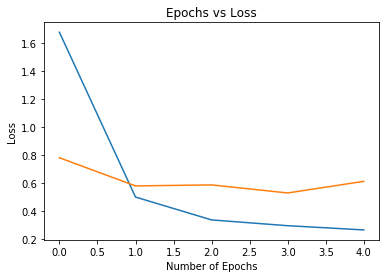

In [ ]:
x = np.arange(n_epochs)

plt.plot(x, Train_loss)
plt.plot(x, Val_loss)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.savefig('Loss.png')
plt.show()

plt.plot(x, Train_acc)
plt.plot(x, Val_acc)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.savefig('Accuracy.png')
plt.show()